In [21]:
import os
import torch
import collections

import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
from torch.utils.data import DataLoader

from FLTrack.models import ShallowNN
from FLTrack.evals import evaluate, pairwise_euclidean_distance
from FLTrack.evals import pairwise_euclidean_distance, layerwise_proximity, layerwise_eccentricity

features = 197
batch_size = 64
loss_fn = torch.nn.L1Loss()

In [22]:
client_ids = ["0_0","0_1","0_2","0_3","0_4"]

In [23]:
dummy = torch.load("checkpt/test6/epoch_500/20_rounds_25_epochs_per_round/_fedl_global_20_25.pth")
critarians = [item for item in dummy]

### Calculating eccentricities in each iteration with $\xi^P$

In [24]:
df_dict = {}
for iter in range(1,21):
    
    state_dicts = {
        key: torch.load("checkpt/test6/epoch_500/20_rounds_25_epochs_per_round/global_" + str(iter) + "/clients/client_model_" + str(key) + ".pth")
        for key in client_ids
    }

    
    #checkpt/test/epoch_500/20_rounds_25_epochs_per_round/global_1/clients/client_model_0_0.pth
    
    layer_prox = {}
    for cri in critarians:
        layer_prox[cri] = layerwise_eccentricity(state_dicts,cri,pairwise_euclidean_distance)
    
    round_frame = pd.DataFrame.from_dict(layer_prox, orient='index')
    round_frame = round_frame.T.reset_index().rename(columns={"index":"client_id"})
    
    averages = [] 
    for index, client in round_frame.iterrows():
        avg = (client['layer_1.weight'] + client['layer_1.bias'] + client['layer_2.weight'] + client['layer_2.bias'] + client['layer_3.weight'] + client['layer_3.bias'])/6
        averages.append(round(avg,4))
    round_frame["average_weight"] = averages
    
    df_dict[iter] = round_frame

In [25]:
ecc_dict = {}
for client in client_ids:   
    client_ecc = []
    for iter in range(1,21):
        client_ecc.append(df_dict[iter][df_dict[iter]['client_id'] == client].average_weight.values.item())
        ecc_dict[client] = client_ecc

In [26]:
dataframe = pd.DataFrame(ecc_dict).T.reset_index().rename(columns={"index": "client_id"})
dataframe['average_parameter_ecc'] = dataframe.apply( lambda row: row.drop('client_id').mean(), axis=1)

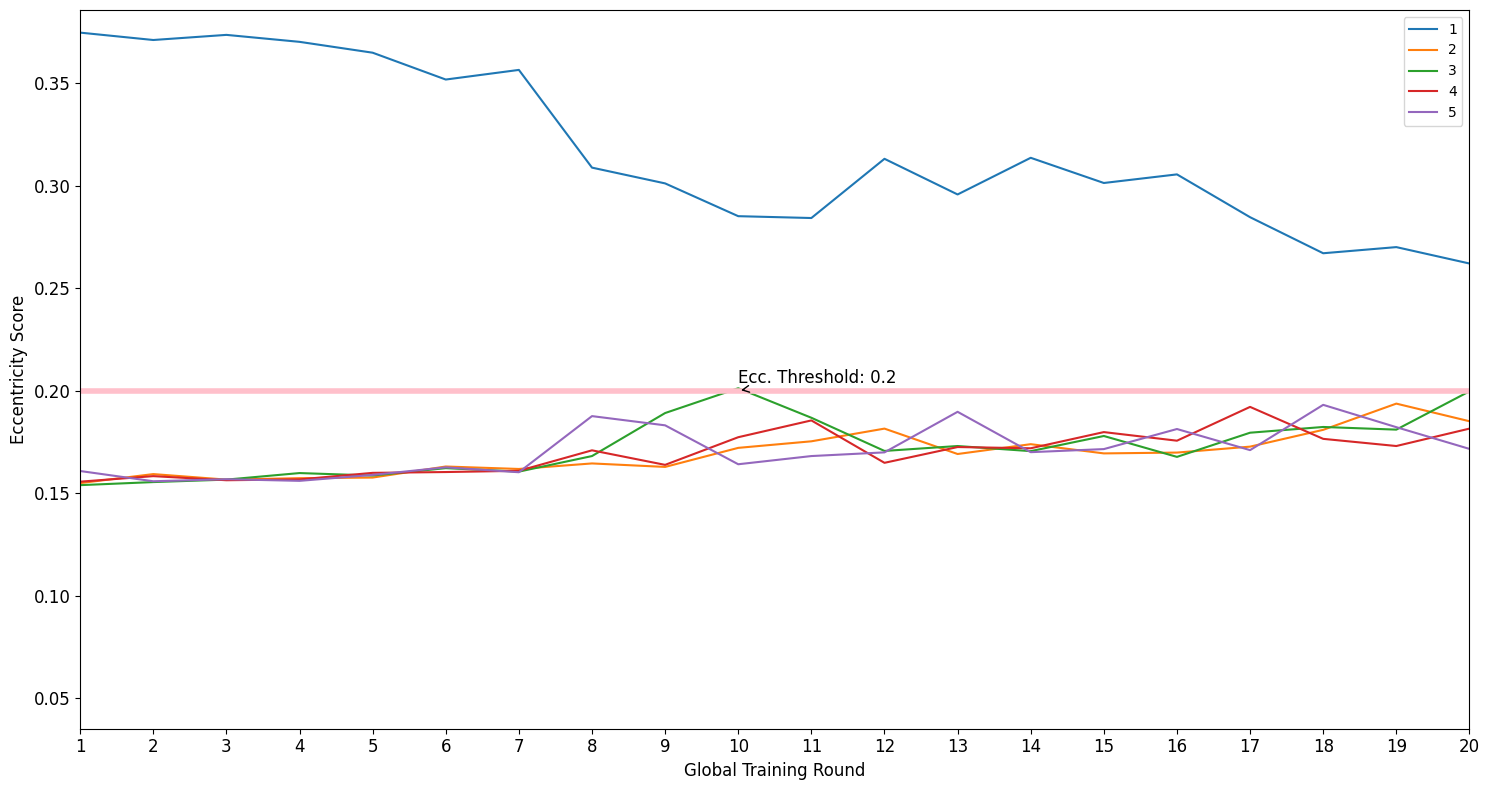

In [30]:
x_values = list(range(1, 21))

plt.figure(figsize=(15, 8))

for i, (key, values) in enumerate(ecc_dict.items()):
    plt.plot(x_values, values, label=str(i + 1))  # Set legend label from 1 to 24
else:        
    plt.plot(x_values, [0.2 for i in range(1, 21)], color='pink',linewidth=4)
    annotation_text = "Ecc. Threshold: 0.2"  
    annotation_x = 10  
    annotation_y = 0.2  
    plt.annotate(annotation_text, xy=(annotation_x, annotation_y), xytext=(annotation_x, annotation_y + 0.004),
                 arrowprops=dict(arrowstyle="->"),fontsize='large')

def legend_without_duplicate_labels(plt):
    handles, labels = plt.gca().get_legend_handles_labels()
    unique = [(h, l) for i, (h, l) in enumerate(zip(handles, labels)) if l not in labels[:i]]
    plt.legend(*zip(*unique))
    
plt.xlim(1,len(values))
plt.ylim(bottom=0.035)
plt.xlabel('Global Training Round', fontsize='large')
plt.ylabel('Eccentricity Score', fontsize='large')
plt.legend(loc='upper right', ncol=4, bbox_to_anchor=(0,0,1,1), fontsize='large', framealpha=1)
legend_without_duplicate_labels(plt)
plt.xticks(x_values, fontsize='large')
plt.yticks(fontsize='large')
plt.tight_layout()
plt.show()

In [ ]:
from FLTrack.evals import evaluate, pairwise_euclidean_distance , influence, calculate_hessian_flattened
from FLTrack.evals import euclidean_distance, manhattan_distance, pairwise_euclidean_distance, accumulated_proximity, full_accumulated_proximity

In [ ]:
def hessian(client):
    
    dataset = torch.load("trainpt/"+ str(client)+".pt")
    data_loader = DataLoader(dataset, batch_size, shuffle=True)                                              
    fed_hessian_mat = calculate_hessian_flattened(fl_model_ckpt,loss_fn,data_loader)
    
    return fed_hessian_mat

In [ ]:
from FLTrack.evals import hessian_eccentricity

global_matrix_dict = {
        key: torch.load(f"hessians/saving/2/{key}.pth")
        for key in client_ids
    }
hess_ecc = hessian_eccentricity(global_matrix_dict,euclidean_distance)

In [ ]:
df_dict = {}
for iter in range(1,3):
    
    global_matrix_dict = {
        key: torch.load(f"hessians/saving/{iter}/{key}.pth")
        for key in client_ids
    }
    
    hess_ecc = hessian_eccentricity(global_matrix_dict,euclidean_distance)
    
    df_dict[iter] = hess_ecc
    
    del global_matrix_dict
    del hess_ecc
    
#saving to avoid recalculation
data = pd.DataFrame(df_dict)

In [ ]:
data

In [ ]:
data['average_parameter_ecc'] = data.apply( lambda row: round(row.mean(),4), axis=1)

In [ ]:
data

In [ ]:
global_round = 3
fl_model_ckpt = ShallowNN(features)
fl_model_ckpt.load_state_dict(torch.load('checkpt/test1/epoch_500/20_rounds_25_epochs_per_round/global_'+str(global_round)+'/global_model.pth'))
for client in client_ids:
    fed_hessian_mat = hessian(client)
    path = f"hessians/saving/{global_round}/{client}.pth"
    if os.path.exists(path):
        torch.save(fed_hessian_mat, path)
    else:
        os.makedirs(os.path.dirname(path), exist_ok=True)
        torch.save(fed_hessian_mat, path)
    print("Client " +str(client)+ " done.")

In [28]:
1/5

0.2